In [1]:
def getAudioInputSize(audioSpecPath):
    firstFilePath = audioSpecPath + os.listdir(audioSpecPath)[0]
    audioInputSize=sio.loadmat(firstFilePath)
    return audioInputSize

def interp_Frame(A,D1,D2):
    #print("A.shape IS ",A.shape)
    
    new_dims = []
    for original_length, new_length in zip(A.shape, (D1,D2)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    coords = np.meshgrid(*new_dims, indexing='ij')
    B = map_coordinates(A, coords)
    print('B.shape IS ',B.shape)
    return B

def getAuidoSpecInput(audio_input,audioSpecPath,audioSpecLength,audioSpecFreq):
    for count, filename in enumerate(sorted(os.listdir(audioSpecPath)),start=0): 
        # Get source (src) addresses
        audioFile  =audioSpecPath+ filename 
        mat=sio.loadmat(audioFile)
        data=np.power(mat['y'],.3)
        
        if(data.shape[0]!=audioSpecLength):
            print(audioSpecPath)
            print(data.shape)
            data= interp_Frame(data,audioSpecLength,audioSpecFreq)
    
        audio_input[count*audioSpecLength:(count+1)*audioSpecLength,:]=data
    return audio_input

def audioSpecClassify(numfiles,audioSpecLength,audio_input,trainRatio):
    numTrain= int(trainRatio * numfiles)
    trainEdge=int(numTrain * audioSpecLength)
    audioInputTrain=audio_input[:trainEdge,:]
    audioInputTest=audio_input[trainEdge:,:]
    return audioInputTrain, audioInputTest

# def audioSpecClassify(numfiles,audioSpecLength,numTrain):
#     trainEdge=int(numTrain * audioSpecLength)
#     audioInputTrain=audio_input[:trainEdge,:]
#     audioInputTest=audio_input[trainEdge:,:]
#     return audioInputTrain, audioInputTest

def createPath(filePath, addFile):
    newFilePath = filePath + addFile
    if not os.path.exists(newFilePath):
        os.mkdir(newFilePath )
    return newFilePath

In [2]:
# Define cost function
def corr2_mse_loss(a,b):
    a = BK.tf.subtract(a, BK.tf.reduce_mean(a))
    b = BK.tf.subtract(b, BK.tf.reduce_mean(b))
    tmp1 = BK.tf.reduce_sum(BK.tf.multiply(a,a))
    tmp2 = BK.tf.reduce_sum(BK.tf.multiply(b,b))
    tmp3 = BK.tf.sqrt(BK.tf.multiply(tmp1,tmp2))
    tmp4 = BK.tf.reduce_sum(BK.tf.multiply(a,b))
    r = -BK.tf.divide(tmp4,tmp3)
    m=BK.tf.reduce_mean(BK.tf.square(BK.tf.subtract(a, b)))
    rm=BK.tf.add(r,m)
    return rm

def constructModel(adam,reg):
    # Construct autoencode model architecture
    config = BK.tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = BK.tf.Session(config=config)
    model=Sequential()
    
    model.add(Dense(512, input_shape=(audioInputTrain.shape[1],)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(32,kernel_regularizer=l1_l2(.001)))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(noise.GaussianNoise(.05))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(audioInputTrain.shape[1]))
    model.compile(loss=corr2_mse_loss, optimizer=adam)
    model.summary()
    return model

def trainModel(model,modelTrainPath,audioInputTrain,audioInputTest,num_iter):
    for i in range(num_iter):
        print('### Autoencoder model, iteration: '+str(i)+'/'+str(num_iter))

        # Train the model
        history = model.fit(audioInputTrain, audioInputTrain, batch_size=128, epochs=1, verbose=1, validation_data=(audioInputTest,audioInputTest))

        # Add the train set loss to the history
        loss_history[i,0]=history.history['loss'][0]

        # Add the validation set loss to the history 
        loss_history[i,1]=history.history['val_loss'][0]

        # Save the loss history
        sio.savemat(modelTrainPath+'loss_history.mat', mdict={'history':loss_history})

        # Save autoencoder model
        model.save(modelTrainPath+'autoencoder.h5')

        # Save the weight of the model
        model.save_weights(modelTrainPath+'autoencoder_weights.h5')
    return loss_history

def plotModelLoss(modelTrainPath,loss_history,num_iter):
    fig = plt.figure()
    plt.title('Loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    loss= loss_history[:,0]
    val_loss= loss_history[:,1]

    plt.plot(loss, 'r-^',label='loss' )
    plt.plot(val_loss, 'b-^',label='val_loss')
    plt.legend(loc='upper right')

    #plt.axis([0, num_iter, -1, -0.9])
    plt.savefig(modelTrainPath+'loss_history.png')  # should before show method
    plt.show()
    
#Define get_activations function
def get_activations(model, layer_in, layer_out, X_batch):
    get_activations = BK.function([model.layers[layer_in].input, BK.learning_phase()], [model.layers[layer_out].output])
    activations = get_activations([X_batch,0])
    return activations

def plotSpectrogram(oriSample,preSample):
    # Plot Original spectrogram
    figure1 = plt.figure(1,figsize=(12, 5))
    plt.imshow(np.power(oriSample,3).T, origin="lower", aspect="auto", interpolation="none")
    plt.title('Original spectrogram')
    
    figure2 = plt.figure(2,figsize=(12, 5))
    plt.imshow(np.power(preSample,3).T, origin="lower", aspect="auto", interpolation="none")
    plt.title('Autoecndoer spectrogram')

In [3]:
# Import libraries
import fnmatch
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import scipy.io as sio
import numpy as np
from keras import backend as BK
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, noise
from keras.layers import Convolution2D, MaxPooling2D, Convolution3D, MaxPooling3D, LSTM
from keras.layers.advanced_activations import ELU
from keras.models import Sequential, Model, load_model
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import map_coordinates


# Define input and output path
inputPath ='D:/Mrs_backup/speech_test/AudSpecs/s9/'
outputPath = 'D:/Mrs_backup/speech_test/autoencoder/s9_trainModel/'
if not os.path.exists(outputPath):
    os.mkdir(outputPath )
        
# Load file and get the size
numfiles=len(fnmatch.filter(os.listdir(inputPath), '*.mat'))
print('Total number of video is: ' + str(numfiles))

audioInputSize = getAudioInputSize(inputPath)
audioSpecLength = audioInputSize['y'].shape[0]
audioSpecFreq = audioInputSize['y'].shape[1]
audio_input =np.empty((numfiles*audioSpecLength,audioSpecFreq), np.dtype('float32'))
print("audioSpecLength is: "+ str(audioSpecLength))
print("audioSpecFreq is: "+ str(audioSpecFreq))
print("Audio input shape is: "+ str(audio_input.shape))
print("------------------------------------------ ")

# Collect audio spectrogram data
audio_input = getAuidoSpecInput(audio_input, inputPath,audioSpecLength,audioSpecFreq)
print("Audio example data is:"+ str(audio_input[0,0:10]))
print("------------------------------------------ ")

# Classify audio spectrogram data into training set(80%) and test set (20%)
audioInputTrain, audioInputTest = audioSpecClassify(numfiles,audioSpecLength,audio_input,trainRatio = 0.8)
print('Shape of all the data:'+str(audio_input.shape))
print('Shape of the train data to autoencoder:'+str( audioInputTrain.shape))
print('Shape of the test data to autoencoder:'+str( audioInputTest.shape))
print("------------------------------------------ ")
    
# Construct model
print('-------------- Summary of model -----------------')
model = constructModel(adam=Adam(lr=.0001), reg=.001)
    
# Train autoencoder model and save model output
print('-------------- Train model -----------------')
num_iter=150
loss_history=np.empty((num_iter,2), dtype='float32')
loss_history = trainModel(model,outputPath,audioInputTrain,audioInputTest,num_iter)
    
# predict one sample
oriSample =  audio_input[:audioSpecLength,:audioSpecFreq]
preSample = model.predict(oriSample)
plotSpectrogram(oriSample,preSample)
print('-------------- End of autoencoder-----------------')

Using TensorFlow backend.
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sally\AppData\Roa

Total number of video is: 100
audioSpecLength is: 376
audioSpecFreq is: 128
Audio input shape is: (37600, 128)
------------------------------------------ 
Audio example data is:[0.05302698 0.02142154 0.0310684  0.05495556 0.04828776 0.02070722
 0.03294741 0.08832758 0.07337199 0.10456933]
------------------------------------------ 
Shape of all the data:(37600, 128)
Shape of the train data to autoencoder:(30080, 128)
Shape of the test data to autoencoder:(7520, 128)
------------------------------------------ 
-------------- Summary of model -----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512

30080/30080 [==============================] - 4s 144us/step - loss: -0.9576 - val_loss: -0.9561
### Autoencoder model, iteration: 24/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 144us/step - loss: -0.9585 - val_loss: -0.9563
### Autoencoder model, iteration: 25/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 147us/step - loss: -0.9589 - val_loss: -0.9571
### Autoencoder model, iteration: 26/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 146us/step - loss: -0.9594 - val_loss: -0.9581
### Autoencoder model, iteration: 27/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 142us/step - loss: -0.9602 - val_loss: -0.9589
### Autoencoder model, iteration: 28/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==

30080/30080 [==============================] - 5s 150us/step - loss: -0.9701 - val_loss: -0.9687
### Autoencoder model, iteration: 66/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 147us/step - loss: -0.9704 - val_loss: -0.9693
### Autoencoder model, iteration: 67/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 148us/step - loss: -0.9705 - val_loss: -0.9687
### Autoencoder model, iteration: 68/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 148us/step - loss: -0.9709 - val_loss: -0.9690
### Autoencoder model, iteration: 69/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 5s 164us/step - loss: -0.9707 - val_loss: -0.9696
### Autoencoder model, iteration: 70/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==

30080/30080 [==============================] - 5s 150us/step - loss: -0.9739 - val_loss: -0.9724
### Autoencoder model, iteration: 108/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 149us/step - loss: -0.9740 - val_loss: -0.9717
### Autoencoder model, iteration: 109/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 150us/step - loss: -0.9741 - val_loss: -0.9730
### Autoencoder model, iteration: 110/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 5s 150us/step - loss: -0.9740 - val_loss: -0.9734
### Autoencoder model, iteration: 111/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 5s 159us/step - loss: -0.9742 - val_loss: -0.9726
### Autoencoder model, iteration: 112/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/3008

30080/30080 [==============================] - 4s 141us/step - loss: -0.9758 - val_loss: -0.9750
### Autoencoder model, iteration: 149/150
Train on 30080 samples, validate on 7520 samples
Epoch 1/1
30080/30080 [==============================] - 4s 140us/step - loss: -0.9759 - val_loss: -0.9727
-------------- End of autoencoder-----------------


-------------- End of autoencoder-----------------


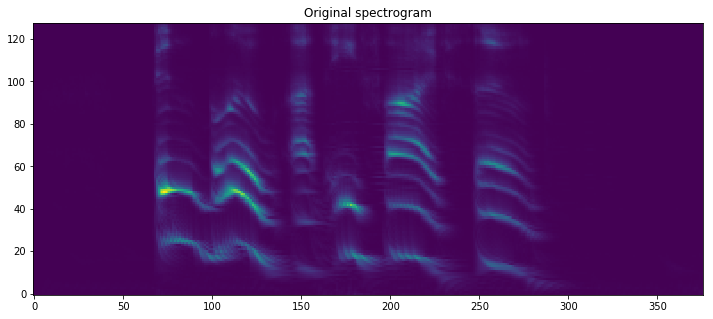

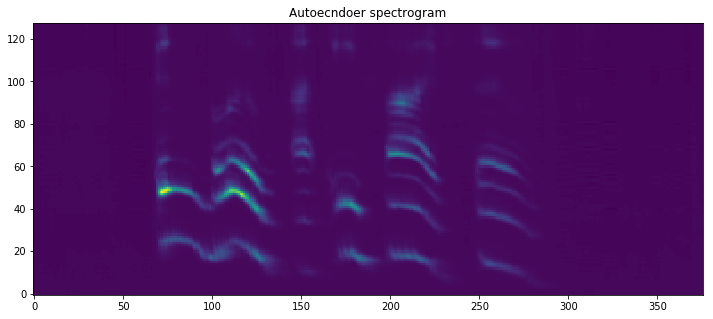

In [4]:
# predict one sample
oriSample =  audio_input[audioSpecLength:audioSpecLength+audioSpecLength,:audioSpecFreq]
preSample = model.predict(oriSample)
plotSpectrogram(oriSample,preSample)
print('-------------- End of autoencoder-----------------')